Heart Failures - ML in healthcare - Lasso Logistic Regression
===

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# from scipy.stats import norm
# from sklearn.preprocessing import StandardScaler
# from scipy import stats
# import warnings
# warnings.filterwarnings('ignore')
%matplotlib inline
import torch
import torch.nn.functional as F
# import param

In [4]:
# import sklearn as sk
# import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc


# , precision_score, recall_score, auc, roc_curve, roc_auc_score, accuracy_score, classification_report 

In [42]:
import param
import panel as pn
pn.extension()
import datetime as dt
import importlib
from importlib import reload
from tqdm import tqdm

In [6]:
import graph as gr
import params as par
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

In [7]:
format_dict = par.create_format_dict()
format_dict

{'Age': '{:.0f}',
 'RestingBP': '{:.0f}',
 'Cholesterol': '{:.0f}',
 'MaxHR': '{:.0f}',
 'FastingBS': '{:.1f}',
 'HeartDisease': '{:.1f}',
 'Oldpeak': '{:.2f}',
 'Accuracy': '{:.1%}',
 'Balanced Accuracy': '{:.1%}',
 'F1 Score': '{:.1%}'}

In [8]:
class LogisticParams(param.Parameterized):
    lambda_multiple          = param.Number(1, bounds=(1,10), doc="lambda Lasso Multiple of 10^x")
    lambda_power             = param.Integer(default=2, bounds=(1,7),doc="lambda Lasso exponent of 10^x")
    lr_multiple              = param.Number(5, bounds=(1,10), doc="Learning Rate Multiple of 10^x")
    lr_power                 = param.Integer(default=3, bounds=(1,9),doc="Learning Rate exponent of 10^x")
    epochs                   = param.Integer(default=5 ,bounds=(1,2000))
    data_set                 = param.ObjectSelector(default="validation",objects=['train', 'validation', 'train + validation', 'test'])
    stand_features           = param.Boolean(True, doc="Whether we want to standardize numerical features")
    use_lasso                = param.Boolean(True)
    use_focal_loss           = param.Boolean(True)
    iter_array               = param.Integer(default=5, bounds=(1,20),doc="How often to save loss and training data, in epochs")
    iter_printing            = param.Integer(default=5, bounds=(1,100),doc="How many epochs between printing")
    add_one_hot_encoded      = param.Boolean(True, doc="Whether to add one hot encoded columns from categorical variables")
    test_size                = param.Number(0.2, bounds=(0.1,0.9), doc="Test size for train_test_split")
    random_state_test_train_split = param.Integer(42)
# pn.Param(CustomExample.param, widgets={
#     'select_string': {'type': pn.widgets.RadioButtonGroup, 'button_type': 'primary'},
#     'select_number': pn.widgets.DiscretePlayer}
# )
base = LogisticParams()

# Import Data

In [9]:
df_heart = pd.read_csv('heart.csv')
# df_heart_test = pd.read_csv('ml4h_data/project1/heart_failure/test_split.csv')
# df_heart_train = pd.read_csv('ml4h_data/project1/heart_failure/train_val_split.csv')
df_heart_test = pd.read_csv('test_split.csv')
df_heart_train = pd.read_csv('train_val_split.csv')

In [10]:
df_heart.head(2)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1


In [11]:
df_heart.describe().style.format(format_dict)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918,918,918,918.0,918,918.00,918.0
mean,54,132,199,0.2,137,0.89,0.6
std,9,19,109,0.4,25,1.07,0.5
min,28,0,0,0.0,60,-2.60,0.0
25%,47,120,173,0.0,120,0.00,0.0
50%,54,130,223,0.0,138,0.60,1.0
75%,60,140,267,0.0,156,1.50,1.0
max,77,200,603,1.0,202,6.20,1.0


## Variables by data types

In [12]:
df_heart.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [13]:
dft = df_heart.dtypes
cols_num = list(dft[dft == 'int64'].index)
cols_num.append('Oldpeak')
cols_num_with_binary = [x for x in cols_num]
cols_num_with_binary_no_label = [x for x in cols_num_with_binary if x != 'HeartDisease']
cols_num.remove('FastingBS')
cols_num.remove('HeartDisease')
cols_num

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [14]:
cols_obj = list(dft[dft == 'object'].index)
cols_obj_pure = [x for x in cols_obj]
cols_obj.append('FastingBS')
cols_obj.append('HeartDisease')
cols_obj

['Sex',
 'ChestPainType',
 'RestingECG',
 'ExerciseAngina',
 'ST_Slope',
 'FastingBS',
 'HeartDisease']

In [15]:
col_names = list(df_heart.columns)
col_names

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease']

## Numerical variables distributions

In [16]:
cols_num

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [17]:
df_heart['FastingBS'].value_counts().values

array([704, 214])

In [18]:
import graph as gr
reload(gr)
import graph as gr

In [19]:
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

/home/pinolej/eth/healthcare/heart/graph.py:139: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


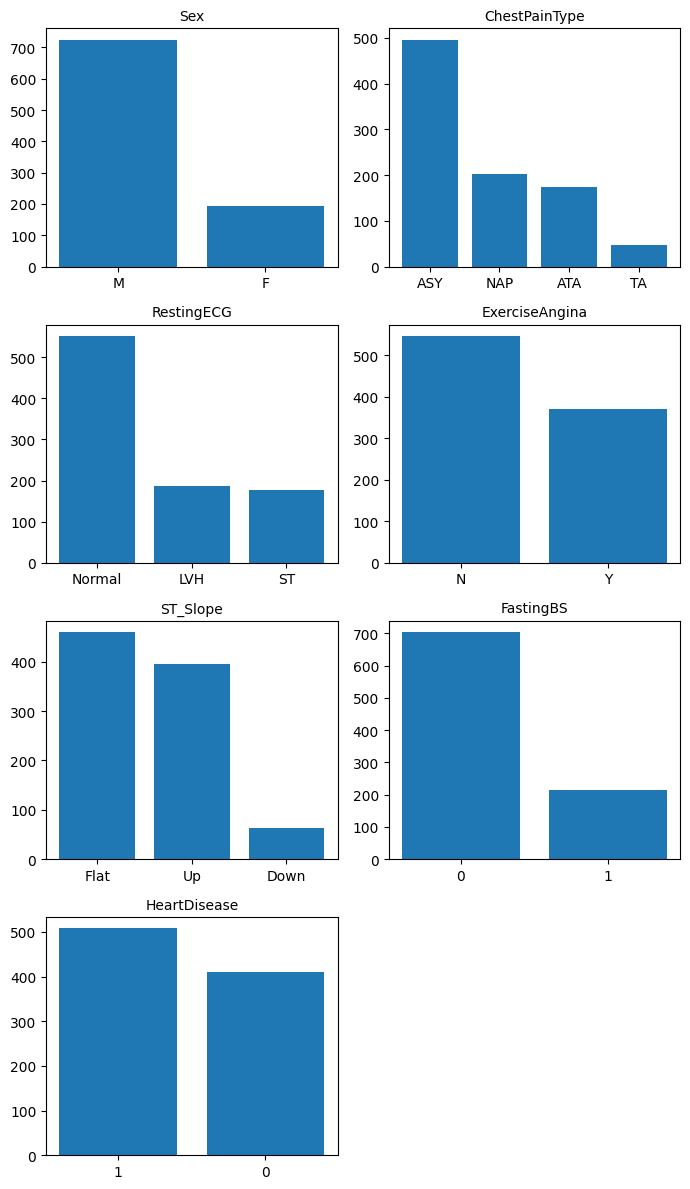

In [20]:
gr.dist_mult_plots(
    df_heart,
    cols=cols_obj,
    figsize=(7, 12),
    ncols=2,
    bar_plot=True,
    fontsize={
        'ax_title': 10,
    },
    custom_bins={'FastingBS': 60},
)

/home/pinolej/eth/healthcare/heart/graph.py:139: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


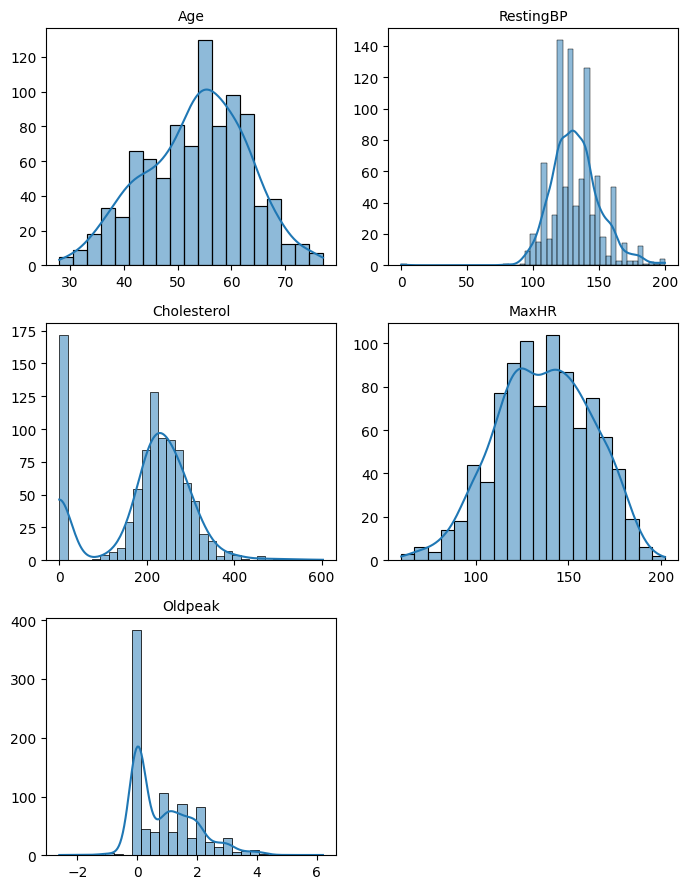

In [21]:
gr.dist_mult_plots(
    df_heart,
    cols=cols_num,
    figsize=(7, 9),
    ncols=2,
    fontsize={
        'ax_title': 10,
    },
    custom_bins={'FastingBS': 60},
)

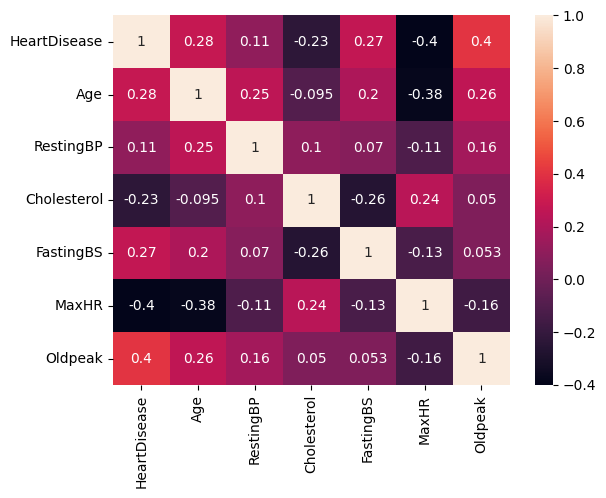

In [22]:
sns.heatmap(df_heart[['HeartDisease'] + cols_num_with_binary_no_label].corr(), annot=True)
plt.show()

## Missing values and Outliers

In [23]:
df_heart.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

# Features Preprocessing

In [24]:
num_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
label_col = 'HeartDisease'
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for col in df_heart.columns:
    if col not in num_features + [label_col] + categorical_features:
        print(f'Column {col} is not in the list of features')

# Benchmark to be dropped for each categorical variable
category_to_drop = {
    'Sex': 'F',
    'ChestPainType': 'ASY',
    'RestingECG': 'Normal',
    'ExerciseAngina': 'N',
    'ST_Slope': 'Flat'
}

In [25]:
pn.Column(pn.Row(base.param.add_one_hot_encoded, base.param.stand_features, base.param.test_size))

BokehModel(combine_events=True, render_bundle={'docs_json': {'b12d0135-69a6-4cbf-8999-6bd427118ba7': {'version…

In [28]:
import py_lib as lib
reload(lib)
import py_lib as lib

In [29]:
train_test_data, final_categorical_features, _ = lib.pre_process_features(
        df_heart_train,
        num_features=num_features,
        categorical_features=categorical_features,
        category_to_drop=category_to_drop,
        label_col=label_col,
        add_one_hot_encoded=base.add_one_hot_encoded,
        add_embeddings=False,
        stand_features=base.stand_features,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
)
X_train, X_test = train_test_data.tensors['X_train'], train_test_data.tensors['X_test']
y_train, y_test = train_test_data.tensors['y_train'], train_test_data.tensors['y_test']
X_train_df = train_test_data.dataframes['X_train']

adding One Hot Encoded


In [36]:
X_train_df['all'].head(3)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Up
135,0.437500,0.700,0.436673,0.0,0.592593,0.853659,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
473,0.729167,0.705,0.461248,1.0,0.414815,0.426829,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
254,0.937500,0.725,0.000000,1.0,0.466667,0.402439,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## Working with the class imbalance

In [37]:
# From ... https://saturncloud.io/blog/how-to-use-class-weights-with-focal-loss-in-pytorch-for-imbalanced-multiclass-classification/#focal-loss
class_counts = np.bincount(y_train)
num_classes = len(class_counts)
total_samples = len(y_train)

class_weights = []
for count in class_counts:
    weight = 1 / (count / total_samples)
    class_weights.append(weight)

class_weights_tensor = torch.FloatTensor(class_weights)

In [38]:
class_weights

[2.2150943396226412, 1.8229813664596275]

# Model Building

In [39]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        be_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-be_loss)
        loss = (self.alpha[targets.long()] * (1 - pt) ** self.gamma * be_loss).mean()
        return loss

In [40]:
class LogisticRegression(torch.nn.Module):
     
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
         

     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs
     

     def compute_loss(self, y_pred, y_true):
         return F.binary_cross_entropy(y_pred, y_true)


     def compute_l1_loss(self, w):
         return torch.abs(w).sum()


def add_l1_loss( model, loss, lambda_lasso: float = 0.01):
    # TODO(pinolej): Check whether can be added to the class
    l1_parameters = []
    for parameter in model.parameters():
        l1_parameters.append(parameter.view(-1))
    l1 = lambda_lasso * model.compute_l1_loss(torch.cat(l1_parameters))
    # Add L1 loss component
    loss += l1
    return loss

    

# Training

In [43]:
pn.Column(
    pn.Row(base.param.use_lasso, base.param.use_focal_loss),
    pn.Row(base.param.lr_power, base.param.lr_multiple),
    pn.Row(base.param.lambda_power, base.param.lambda_multiple)
    )

BokehModel(combine_events=True, render_bundle={'docs_json': {'8e33cca2-a6a9-497a-93e5-016a8ef5e4d0': {'version…

In [44]:
lr = base.lr_multiple * 10**(-base.lr_power)
print('learning rate is {} multiplied by 10 power {}, which yields {:.8f}'.format(base.lr_multiple, -base.lr_power, lr))
lambda_lasso = base.lambda_multiple * 10**(-base.lambda_power)
print('lambda_lasso is {} multiplied by 10 power {}, which yields {:.6f}'.format(base.lambda_multiple, -base.lambda_power, lambda_lasso))

learning rate is 5 multiplied by 10 power -3, which yields 0.00500000
lambda_lasso is 1 multiplied by 10 power -2, which yields 0.010000


In [46]:
pn.Column(
    pn.Row(base.param.epochs, base.param.iter_array, base.param.iter_printing),
    )

BokehModel(combine_events=True, render_bundle={'docs_json': {'99e8dbf6-404f-483d-9be4-32bcbb34b36b': {'version…

In [47]:
input_dim = len(num_features + final_categorical_features)
output_dim = 1 # Single binary output
model = LogisticRegression(input_dim,output_dim)
if base.use_focal_loss:
    criterion = FocalLoss(alpha=class_weights_tensor.long(), gamma=2)
else:
    criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
iter_printing_effective = int(base.epochs/base.iter_printing)
print('iter_printing_effective is {}'.format(iter_printing_effective))
# torch.manual_seed(0) # keep things reproducible

iter_printing_effective is 74


In [50]:
losses = []
losses_test = []
Iterations = []
iter = 0
for epoch in tqdm(range(int(base.epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train['all'])  # Perform forward pass
    loss = criterion(torch.squeeze(outputs), labels) # Compute loss
    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

    # Compute L1 loss component
    if base.use_lasso:
        loss = add_l1_loss(model, loss, lambda_lasso=lambda_lasso)

    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter+=1
    if iter%base.iter_array==0:
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = torch.squeeze(model(X_test['all']))
            loss_test = criterion(outputs_test, y_test)
            loss_test = add_l1_loss(model, loss_test, lambda_lasso=lambda_lasso)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_test.size(0)
            correct_test += np.sum(predicted_test == y_test.detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)

            if iter%iter_printing_effective==0:
                print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
                print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

Training Epochs: 100%|██████████| 374/374 [00:00<00:00, 1872.18it/s]

Iteration: 370. 
Test - Loss: 0.2246609777212143. Accuracy: 66.66666666666667
Train -  Loss: 0.23430877923965454. Accuracy: 59.45485519591141



Text(0, 0.5, 'Focal Loss')

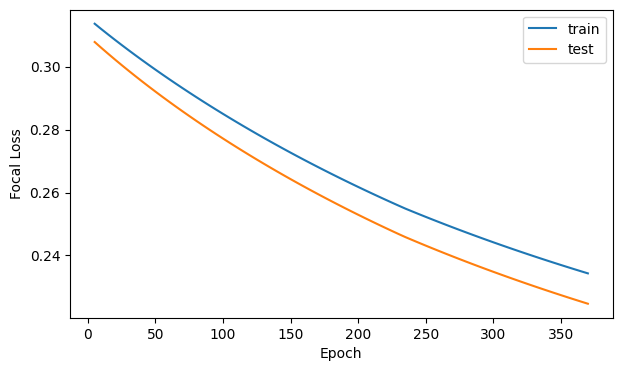

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (7,4))
ax.plot(Iterations,losses, label='train')
ax.plot(Iterations,losses_test, label='test')
ax.legend()
ax.set_xlabel('Epoch')
loss_type = 'Focal Loss' if base.use_focal_loss else 'BCE Loss'
ax.set_ylabel(loss_type)
# fig.show()

# Evaluation

## Features Importance

linear.weight
linear.bias
tensor([[ 0.1894, -0.1001, -0.0913,  0.2283, -0.2714,  0.2665, -0.1020, -0.1224,
         -0.1719,  0.1475, -0.1760, -0.1493, -0.0356,  0.1111, -0.0793]])


<Axes: ylabel='Feature'>

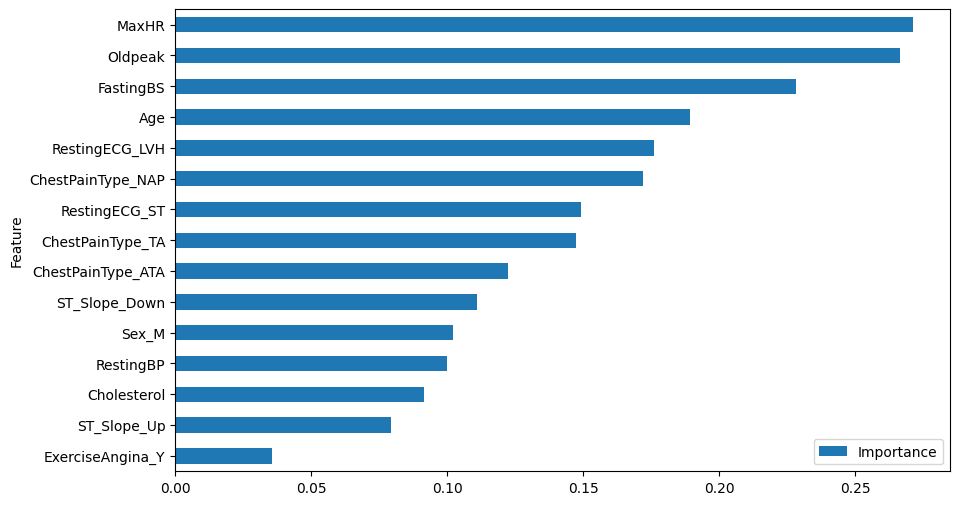

In [53]:
for name, model_param in model.named_parameters():
    print(name)
    if name == 'linear.weight':
        weights = model_param.data
print(weights)
coefficients = weights.detach().numpy()
feature_importance = pd.DataFrame({'Feature': X_train_df['all'].columns, 'Importance': np.abs(coefficients.flatten())})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

## Predictions performances

In [55]:
pn.Row(base.param.data_set)

BokehModel(combine_events=True, render_bundle={'docs_json': {'3ddc7d62-ada3-4dc5-b76d-caf88604e2d5': {'version…

In [58]:
dataset_choice = {
    'train': {
        'data': {
            'x': train_test_data.tensors['X_train']['all'],
            'y': train_test_data.tensors['y_train'],
        },
        'already_processed': True,
    },
    'validation': {
        'data': {
            'x': train_test_data.tensors['X_test']['all'],
            'y': train_test_data.tensors['y_test'],
        },
        'already_processed': True,
    },
    'train + validation': {
        'data': df_heart_train,
        'already_processed': False,
    },
    'test': {
        'data': df_heart_test,
        'already_processed': False,
    },
    'all': {
        'data': df_heart,
        'already_processed': False,
    },
}
print('We are displaying evaluation over the {} dataset'.format(base.data_set.upper()))
data_specs = dataset_choice[base.data_set]

We are displaying evaluation over the TEST dataset


In [60]:
import py_lib as lib
reload(lib)
import py_lib as lib

In [61]:
if data_specs['already_processed']:
    print('Data were already processed for training.')
    x_features = data_specs['data']['x']
    y_true = data_specs['data']['y']
else:
        print('Processing data')
        processed_data, _, _ = lib.pre_process_features(
                data_specs['data'],
                num_features=num_features,
                categorical_features=categorical_features,
                category_to_drop=category_to_drop,
                label_col=label_col,
                add_one_hot_encoded=base.add_one_hot_encoded,
                add_embeddings=False,
                stand_features=base.stand_features,
                test_size=base.test_size,
                random_state=base.random_state_test_train_split,
                split_data=False,
        )
        x_features = processed_data.tensors['X_train']['all']
        y_true = processed_data.tensors['y_train']

Processing data
adding One Hot Encoded


In [62]:
y_pred_tensor = torch.squeeze(model(x_features))
y_pred_round_tensor = y_pred_tensor.round()
y_pred = y_pred_tensor.detach().numpy()
y_pred_round = y_pred_round_tensor.detach().numpy()

In [63]:
from torchmetrics.classification import BinaryF1Score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
acc = accuracy_score(y_true, y_pred_round, normalize = True)  
bal_acc=balanced_accuracy_score(y_true,y_pred_round)
f1_score = BinaryF1Score()
f1 = f1_score(y_pred_round_tensor, y_true).numpy()
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [64]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,66.8%,69.2%,67.4%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

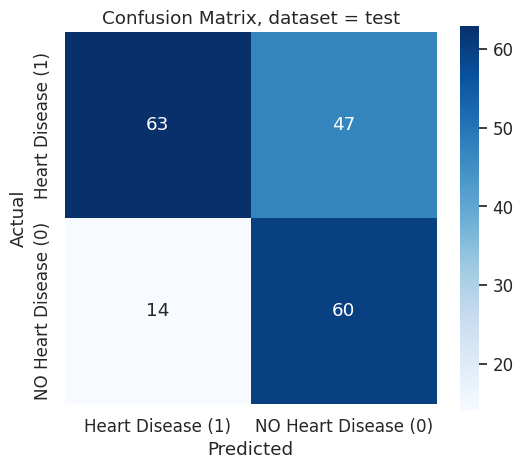

In [65]:
logreg_conf_matrix = confusion_matrix(y_true, y_pred_round)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [230]:
tpr_manual = 88 / (88+22)
tnr_manual = 62 / (62+12)
(tpr_manual + tnr_manual) / 2

0.818918918918919

In [228]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_performance = auc(fpr, tpr)

/home/pinolej/eth/healthcare/heart/graph.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  )
/home/pinolej/eth/healthcare/heart/graph.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  i, j = divmod(item, ncols)


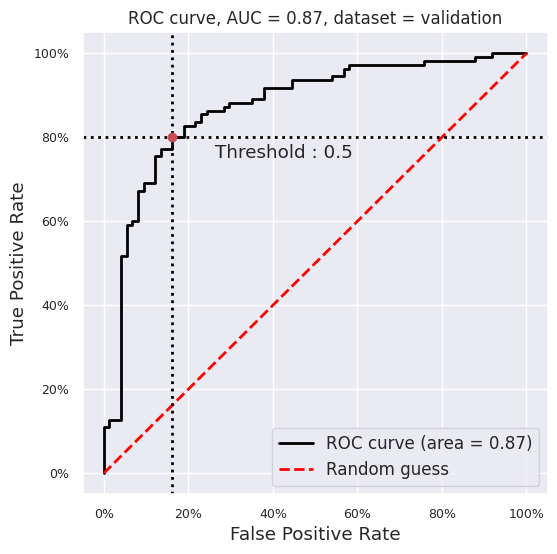

In [229]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)

## Visual explorations, to check

In [231]:
dim_1 = 0
dim_2 = 1

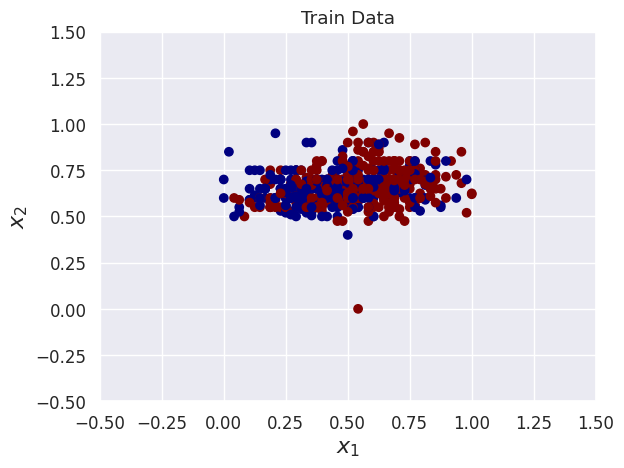

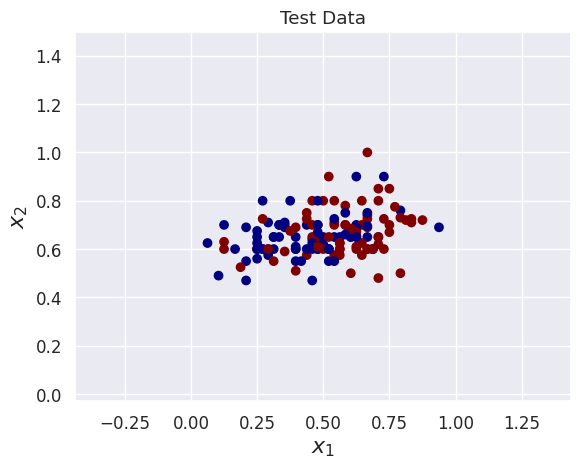

In [232]:
def model_plot(model,X,y,title,dim_1,dim_2):
    parm = {}
    b = []
    for name, param in model.named_parameters():
        parm[name]=param.detach().numpy()  
    
    w = parm['linear.weight'][0]
    b = parm['linear.bias'][0]
    plt.scatter(X[:, dim_1], X[:, dim_2], c=y,cmap='jet')
    u = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
    plt.plot(u, (0.5-b-w[0]*u)/w[1])
    plt.xlim(X[:, dim_1].min()-0.5, X[:, 0].max()+0.5)
    plt.ylim(X[:, dim_2].min()-0.5, X[:, 1].max()+0.5)
    plt.xlabel(r'$\boldsymbol{x_1}$',fontsize=16) # Normally you can just add the argument fontweight='bold' but it does not work with latex
    plt.ylabel(r'$\boldsymbol{x_2}$',fontsize=16)
    plt.title(title)
    plt.show()


# Train Data
model_plot(model,X_train,y_train,'Train Data',dim_1,dim_2)

# Test Dataset Results
model_plot(model,X_test,y_test,'Test Data',dim_1,dim_2)

# Appendix

In [43]:
model_2 = torch.nn.Sequential(
    torch.nn.Linear(3, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 1),
)

print(model_2(torch.randn(4, 3))) # feed it 4 random 3-dim. vectors

tensor([[0.3709],
        [0.4930],
        [0.4063],
        [0.3934]], grad_fn=<AddmmBackward0>)


In [ ]:
# class Example(BaseClass):
#     """An example Parameterized class"""
#     timestamps = []

#     boolean                 = param.Boolean(True, doc="A sample Boolean parameter")
#     color                   = param.Color(default='#FFFFFF')
#     date                    = param.Date(dt.datetime(2017, 1, 1),
#                                          bounds=(dt.datetime(2017, 1, 1), dt.datetime(2017, 2, 1)))
#     select_string           = param.ObjectSelector(default="yellow",objects=["red","yellow","green"])
#     select_fn               = param.ObjectSelector(default=list,objects=[list,set,dict])
#     int_list                = param.ListSelector(default=[3,5], objects=[1,3,5,7,9],precedence=0.5)
#     single_file             = param.FileSelector(path='../../*/*.py*',precedence=0.5)
#     multiple_files          = param.MultiFileSelector(path='../../*/*.py?',precedence=0.5)
#     record_timestamp        = param.Action(lambda x: x.timestamps.append(dt.datetime.now()),
#                                            doc="""Record timestamp.""",precedence=0.7)

In [ ]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28 * 1, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)
  
  def compute_l1_loss(self, w):
      return torch.abs(w).sum()

# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-pytorch.md

In [ ]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        be_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-be_loss)
        print('be loss is {}'.format(be_loss))
        print('pt is {}'.format(pt))
        loss = (self.alpha[targets] * (1 - pt) ** self.gamma * be_loss).mean()
        return loss